<a href="https://colab.research.google.com/github/aalvarez359/3dunet-vs-medam-brain-tumor/blob/main/metrics/3d_unet_seg_msd_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mount Drive and Load CSVs

In [ ]:
# Cell 1: Setup and load all CSVs

from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Directory with your 8 CSVs
CSV_DIR = "/content/drive/MyDrive/Inference_CSVs"
FIG_DIR = os.path.join(CSV_DIR, "Figures")
os.makedirs(FIG_DIR, exist_ok=True)

# List of files and human-readable model names
model_files = [
    ("MedSAM2_BRATS_3mod_test_results.csv",        "MedSAM2 MSD 3-mod (RGB)"),
    ("UNet4mod_MSD_test_results.csv",              "UNet MSD 4-mod"),
    ("MedSAM2_BRATS_FLAIR_only_test_results.csv",  "MedSAM2 MSD FLAIR-only"),
    ("UNetFLAIR_MSD_test_results.csv",             "UNet MSD FLAIR-only"),
    ("MedSAM2_BraTS2024_t2f_test_results.csv",     "MedSAM2 BraTS2024 T2F-only"),
    ("UNet_t2f_BraTS2024_test_results.csv",        "UNet BraTS2024 T2F-only"),
    ("MedSAM2_BraTS2024_t2w_test_results.csv",     "MedSAM2 BraTS2024 T2W-only"),
    ("UNet_t2w_BraTS2024_test_results.csv",        "UNet BraTS2024 T2W-only"),
]

def find_whole_tumor_column(df, fname):
    """
    Try to find the whole tumor dice column by looking for
    'dice_whole_tumor' in the column name.
    """
    candidates = [c for c in df.columns if "dice_whole_tumor" in c.lower()]
    if not candidates:
        print(f"⚠️ No 'dice_whole_tumor' column found in {fname}. Columns: {list(df.columns)}")
        return None
    if len(candidates) > 1:
        print(f"ℹ️ Multiple WT dice columns in {fname}, using {candidates[0]}")
    return candidates[0]

rows = []

for fname, model_name in model_files:
    path = os.path.join(CSV_DIR, fname)
    if not os.path.exists(path):
        print(f"⚠️ File missing: {path}")
        continue

    df = pd.read_csv(path)
    wt_col = find_whole_tumor_column(df, fname)
    if wt_col is None:
        continue

    # Mark whether this is a UNet model
    is_unet = "unet" in model_name.lower()

    # Optional per-class columns (mainly for UNet)
    edema_col  = "dice_edema" if "dice_edema" in df.columns else None
    netc_col   = "dice_netc" if "dice_netc" in df.columns else None
    et_col     = "dice_et" if "dice_et" in df.columns else None
    mean_cls_col = "dice_mean_tumor_classes" if "dice_mean_tumor_classes" in df.columns else None

    for _, row in df.iterrows():
        rows.append({
            "model": model_name,
            "is_unet": is_unet,
            "case_id": row.get("case_id", None),
            "wt_dice": row[wt_col],

            # Per-class, may be NaN for MedSAM2
            "dice_edema": row[edema_col] if edema_col else np.nan,
            "dice_netc": row[netc_col] if netc_col else np.nan,
            "dice_et": row[et_col] if et_col else np.nan,
            "dice_mean_tumor_classes": row[mean_cls_col] if mean_cls_col else np.nan,
        })

results_df = pd.DataFrame(rows)

print("Loaded results_df with shape:", results_df.shape)
display(results_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded results_df with shape: (1470, 8)


,model,is_unet,case_id,wt_dice,dice_edema,dice_netc,dice_et,dice_mean_tumor_classes
0,MedSAM2 MSD 3-mod (RGB),False,BRATS_137,0.703677,NaN,NaN,NaN,NaN
1,MedSAM2 MSD 3-mod (RGB),False,BRATS_441,0.864444,NaN,NaN,NaN,NaN
2,MedSAM2 MSD 3-mod (RGB),False,BRATS_302,0.754819,NaN,NaN,NaN,NaN
3,MedSAM2 MSD 3-mod (RGB),False,BRATS_456,0.896043,NaN,NaN,NaN,NaN
4,MedSAM2 MSD 3-mod (RGB),False,BRATS_136,0.506874,NaN,NaN,NaN,NaN


Summary Table

In [ ]:
# Cell 2 (updated): Build summary table, split into MSD vs BraTS2024, and save as CSVs

import numpy as np
import os
import pandas as pd

model_order = [
    "MedSAM2 MSD 3-mod (RGB)",
    "UNet MSD 4-mod",
    "MedSAM2 MSD FLAIR-only",
    "UNet MSD FLAIR-only",
    "MedSAM2 BraTS2024 T2F-only",
    "UNet BraTS2024 T2F-only",
    "MedSAM2 BraTS2024 T2W-only",
    "UNet BraTS2024 T2W-only",
]

summary_rows = []

for model_name, group in results_df.groupby("model"):
    wt = group["wt_dice"].dropna()

    mean_wt = wt.mean()
    nonzero_wt = wt[wt > 0]
    min_wt_nonzero = nonzero_wt.min() if len(nonzero_wt) > 0 else np.nan
    max_wt = wt.max()

    # Defaults for U-Net-only fields
    mean_edema = mean_netc = mean_et = mean_tumor_mean = np.nan

    is_unet = bool(group["is_unet"].iloc[0])
    if is_unet:
        if "dice_edema" in group.columns:
            mean_edema = group["dice_edema"].mean()
        if "dice_netc" in group.columns:
            mean_netc = group["dice_netc"].mean()
        if "dice_et" in group.columns:
            mean_et = group["dice_et"].mean()
        if "dice_mean_tumor_classes" in group.columns:
            mean_tumor_mean = group["dice_mean_tumor_classes"].mean()

    summary_rows.append({
        "Model": model_name,
        "UNet": is_unet,
        "Mean Whole Tumor Dice": mean_wt,
        "Minimum Whole Tumor Dice (nonzero)": min_wt_nonzero,
        "Maximum Whole Tumor Dice": max_wt,
        "Mean Dice Edema (UNet)": mean_edema,
        "Mean Dice NETC (UNet)": mean_netc,
        "Mean Dice ET (UNet)": mean_et,
        "Mean of Dice Tumor Means (UNet)": mean_tumor_mean,
    })

summary_df = pd.DataFrame(summary_rows)

# Reorder rows to your desired order
summary_df = summary_df.set_index("Model").reindex(model_order).reset_index()

print("Full summary table:")
display(summary_df)

# ---- Split into MSD and BraTS2024 subsets ----
msd_models = model_order[:4]
brats_models = model_order[4:]

summary_msd = summary_df[summary_df["Model"].isin(msd_models)].reset_index(drop=True)
summary_brats = summary_df[summary_df["Model"].isin(brats_models)].reset_index(drop=True)

print("\nMSD models summary:")
display(summary_msd)

print("\nBraTS2024 models summary:")
display(summary_brats)

# ---- Save as CSVs for your report ----
os.makedirs(CSV_DIR, exist_ok=True)
full_path   = os.path.join(CSV_DIR, "Model_Summary_WholeTumor_and_ClassDice_ALL.csv")
msd_path    = os.path.join(CSV_DIR, "Model_Summary_MSD.csv")
brats_path  = os.path.join(CSV_DIR, "Model_Summary_BraTS2024.csv")

summary_df.to_csv(full_path, index=False)
summary_msd.to_csv(msd_path, index=False)
summary_brats.to_csv(brats_path, index=False)

print("\nSaved summary CSVs:")
print("  Full:   ", full_path)
print("  MSD:    ", msd_path)
print("  BraTS24:", brats_path)


Full summary table:


,Model,UNet,Mean Whole Tumor Dice,Minimum Whole Tumor Dice (nonzero),Maximum Whole Tumor Dice,Mean Dice Edema (UNet),Mean Dice NETC (UNet),Mean Dice ET (UNet),Mean of Dice Tumor Means (UNet)
0,MedSAM2 MSD 3-mod (RGB),False,0.804777,0.313033,0.947656,NaN,NaN,NaN,NaN
1,UNet MSD 4-mod,True,0.905694,0.694947,0.966630,0.805429,0.588337,0.775099,0.722955
2,MedSAM2 MSD FLAIR-only,False,0.859964,0.506951,0.965276,NaN,NaN,NaN,NaN
3,UNet MSD FLAIR-only,True,0.885214,0.503452,0.965313,0.723640,0.327494,0.425372,0.492168
4,MedSAM2 BraTS2024 T2F-only,False,0.741260,0.049504,0.954203,NaN,NaN,NaN,NaN
5,UNet BraTS2024 T2F-only,True,0.769445,0.005374,0.959315,NaN,NaN,NaN,NaN
6,MedSAM2 BraTS2024 T2W-only,False,0.750379,0.091551,0.933802,NaN,NaN,NaN,NaN
7,UNet BraTS2024 T2W-only,True,0.701684,0.043760,0.929484,NaN,NaN,NaN,NaN



MSD models summary:


,Model,UNet,Mean Whole Tumor Dice,Minimum Whole Tumor Dice (nonzero),Maximum Whole Tumor Dice,Mean Dice Edema (UNet),Mean Dice NETC (UNet),Mean Dice ET (UNet),Mean of Dice Tumor Means (UNet)
0,MedSAM2 MSD 3-mod (RGB),False,0.804777,0.313033,0.947656,NaN,NaN,NaN,NaN
1,UNet MSD 4-mod,True,0.905694,0.694947,0.966630,0.805429,0.588337,0.775099,0.722955
2,MedSAM2 MSD FLAIR-only,False,0.859964,0.506951,0.965276,NaN,NaN,NaN,NaN
3,UNet MSD FLAIR-only,True,0.885214,0.503452,0.965313,0.723640,0.327494,0.425372,0.492168



BraTS2024 models summary:


,Model,UNet,Mean Whole Tumor Dice,Minimum Whole Tumor Dice (nonzero),Maximum Whole Tumor Dice,Mean Dice Edema (UNet),Mean Dice NETC (UNet),Mean Dice ET (UNet),Mean of Dice Tumor Means (UNet)
0,MedSAM2 BraTS2024 T2F-only,False,0.741260,0.049504,0.954203,NaN,NaN,NaN,NaN
1,UNet BraTS2024 T2F-only,True,0.769445,0.005374,0.959315,NaN,NaN,NaN,NaN
2,MedSAM2 BraTS2024 T2W-only,False,0.750379,0.091551,0.933802,NaN,NaN,NaN,NaN
3,UNet BraTS2024 T2W-only,True,0.701684,0.043760,0.929484,NaN,NaN,NaN,NaN



Saved summary CSVs:
  Full:    /content/drive/MyDrive/Inference_CSVs/Model_Summary_WholeTumor_and_ClassDice_ALL.csv
  MSD:     /content/drive/MyDrive/Inference_CSVs/Model_Summary_MSD.csv
  BraTS24: /content/drive/MyDrive/Inference_CSVs/Model_Summary_BraTS2024.csv


Box-and-Whisker Plot

/tmp/ipython-input-2404938163.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=model_order, showmeans=True)


Saved boxplot to: /content/drive/MyDrive/Inference_CSVs/Figures/Fig_Boxplot_WT_Dice_All_Models.png


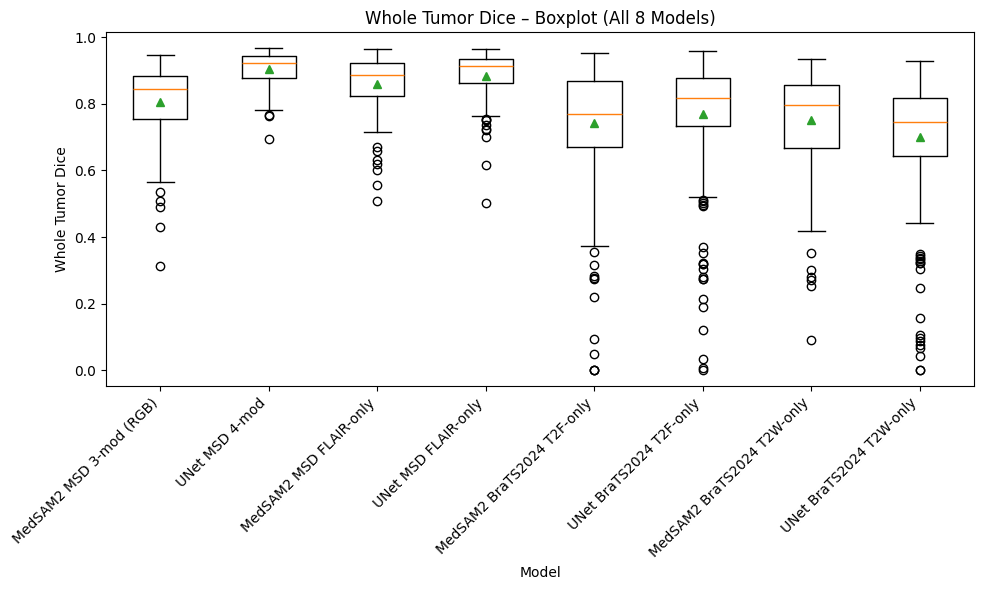

In [ ]:
# Cell 3: Box-and-whisker plot of Whole Tumor Dice (all 8 models)

plt.figure(figsize=(10, 6))

# Ensure consistent ordering
results_df["model"] = pd.Categorical(results_df["model"], categories=model_order, ordered=True)

data_to_plot = [results_df[results_df["model"] == m]["wt_dice"].dropna().values
                for m in model_order]

plt.boxplot(data_to_plot, labels=model_order, showmeans=True)

plt.ylabel("Whole Tumor Dice")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.title("Whole Tumor Dice – Boxplot (All 8 Models)")
plt.tight_layout()

boxplot_path = os.path.join(FIG_DIR, "Fig_Boxplot_WT_Dice_All_Models.png")
plt.savefig(boxplot_path, dpi=300, bbox_inches="tight")
print("Saved boxplot to:", boxplot_path)

plt.show()


Sorted Whole Tumor Dice line plot

Saved sorted WT Dice plot to: /content/drive/MyDrive/Inference_CSVs/Figures/Fig_Sorted_WT_Dice_All_Models.png


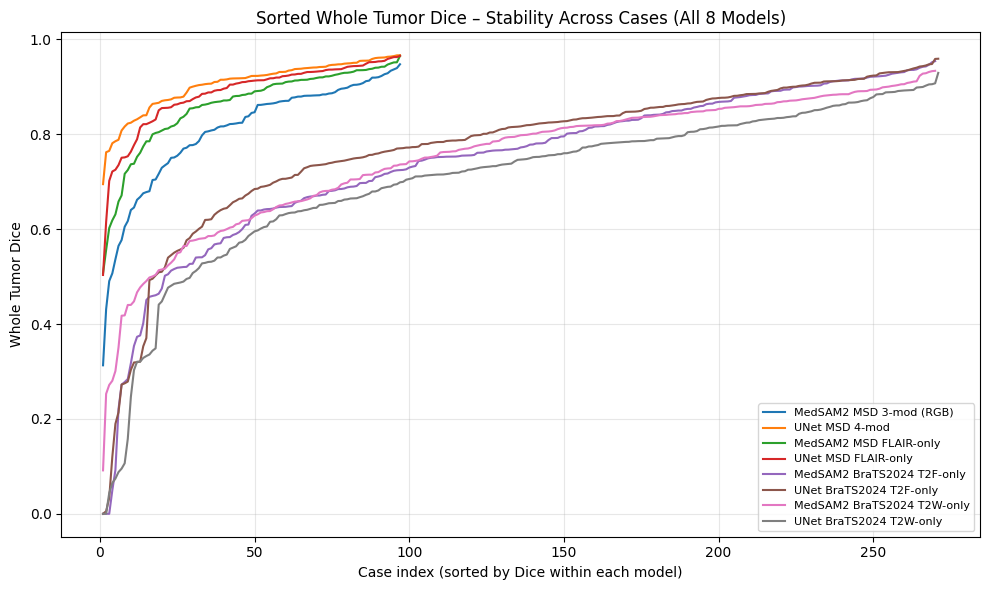

In [ ]:
# Cell 4: Sorted Whole Tumor Dice line plot (all 8 models)

plt.figure(figsize=(10, 6))

for model_name in model_order:
    vals = results_df.loc[results_df["model"] == model_name, "wt_dice"].dropna().values
    if len(vals) == 0:
        continue
    vals_sorted = np.sort(vals)
    x = np.arange(1, len(vals_sorted) + 1)
    plt.plot(x, vals_sorted, label=model_name)

plt.xlabel("Case index (sorted by Dice within each model)")
plt.ylabel("Whole Tumor Dice")
plt.title("Sorted Whole Tumor Dice – Stability Across Cases (All 8 Models)")
plt.legend(fontsize=8, loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

sorted_plot_path = os.path.join(FIG_DIR, "Fig_Sorted_WT_Dice_All_Models.png")
plt.savefig(sorted_plot_path, dpi=300, bbox_inches="tight")
print("Saved sorted WT Dice plot to:", sorted_plot_path)

plt.show()


Bar chart of mean Whole Tumor Dice

/tmp/ipython-input-399319183.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("model")["wt_dice"]


Saved mean WT Dice barplot to: /content/drive/MyDrive/Inference_CSVs/Figures/Fig_Barplot_Mean_WT_Dice_All_Models.png


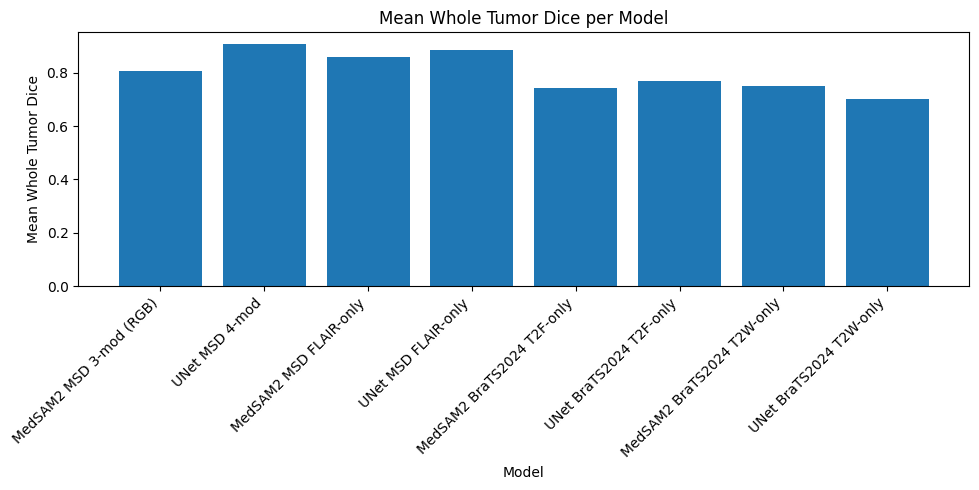

In [ ]:
# Cell 5: Bar chart of mean Whole Tumor Dice (all 8 models)

mean_wt_per_model = (
    results_df
    .groupby("model")["wt_dice"]
    .mean()
    .reindex(model_order)
)

plt.figure(figsize=(10, 5))
plt.bar(mean_wt_per_model.index, mean_wt_per_model.values)
plt.ylabel("Mean Whole Tumor Dice")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.title("Mean Whole Tumor Dice per Model")
plt.tight_layout()

barplot_path = os.path.join(FIG_DIR, "Fig_Barplot_Mean_WT_Dice_All_Models.png")
plt.savefig(barplot_path, dpi=300, bbox_inches="tight")
print("Saved mean WT Dice barplot to:", barplot_path)

plt.show()


Wilcoxon Signed-Rank

In [ ]:
# Cell 6: Wilcoxon signed-rank tests for MedSAM2 vs UNet (WT Dice)

from scipy.stats import wilcoxon
import numpy as np
import pandas as pd

# Helper to extract aligned WT Dice arrays for a pair of models
def get_aligned_pair(results_df, model_a, model_b):
    sub = results_df[results_df["model"].isin([model_a, model_b])].copy()
    pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")
    # drop rows where one of the models is missing
    pivot = pivot.dropna(subset=[model_a, model_b])
    a_vals = pivot[model_a].values
    b_vals = pivot[model_b].values
    return a_vals, b_vals, pivot.index.values

pairs = [
    ("MedSAM2 MSD 3-mod (RGB)",      "UNet MSD 4-mod"),
    ("MedSAM2 MSD FLAIR-only",       "UNet MSD FLAIR-only"),
    ("MedSAM2 BraTS2024 T2F-only",   "UNet BraTS2024 T2F-only"),
    ("MedSAM2 BraTS2024 T2W-only",   "UNet BraTS2024 T2W-only"),
]

wilcoxon_rows = []

for model_a, model_b in pairs:
    a_vals, b_vals, case_ids = get_aligned_pair(results_df, model_a, model_b)
    n = len(a_vals)
    if n == 0:
        print(f"No overlapping cases for {model_a} vs {model_b}, skipping.")
        continue

    # Wilcoxon signed-rank test (paired)
    stat, p = wilcoxon(a_vals, b_vals, alternative="two-sided", zero_method="wilcox")

    diff = b_vals - a_vals
    mean_diff = np.mean(diff)
    median_diff = np.median(diff)

    wilcoxon_rows.append({
        "Comparison": f"{model_b} vs {model_a}",
        "N (cases)": n,
        "Mean Δ WT Dice (UNet - MedSAM2)": mean_diff,
        "Median Δ WT Dice (UNet - MedSAM2)": median_diff,
        "Wilcoxon statistic": stat,
        "p-value": p,
        "Significant (p < 0.05)": p < 0.05
    })

wilcoxon_df = pd.DataFrame(wilcoxon_rows)
print("\nWilcoxon signed-rank test results (WT Dice):")
display(wilcoxon_df)

# Save for inclusion in report
wilcoxon_path = os.path.join(CSV_DIR, "Wilcoxon_WTdice_MedSAM2_vs_UNet.csv")
wilcoxon_df.to_csv(wilcoxon_path, index=False)
print("Saved Wilcoxon results to:", wilcoxon_path)



Wilcoxon signed-rank test results (WT Dice):


/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")
/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")
/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")
/tmp/ipython-input-3449882430.p

,Comparison,N (cases),Mean Δ WT Dice (UNet - MedSAM2),Median Δ WT Dice (UNet - MedSAM2),Wilcoxon statistic,p-value,Significant (p < 0.05)
0,UNet MSD 4-mod vs MedSAM2 MSD 3-mod (RGB),97,0.100917,0.071898,119.0,4.547491e-16,True
1,UNet MSD FLAIR-only vs MedSAM2 MSD FLAIR-only,97,0.025250,0.021296,1330.0,1.661816e-04,True
2,UNet BraTS2024 T2F-only vs MedSAM2 BraTS2024 T...,270,0.027847,0.018852,14488.0,3.052892e-03,True
3,UNet BraTS2024 T2W-only vs MedSAM2 BraTS2024 T...,270,-0.049175,-0.028011,12987.0,3.610155e-05,True


Saved Wilcoxon results to: /content/drive/MyDrive/Inference_CSVs/Wilcoxon_WTdice_MedSAM2_vs_UNet.csv


Scatter plots (WT Dice) for MedSAM2 vs UNet

In [ ]:
# Cell 4: Scatter plots (WT Dice) for MedSAM2 vs UNet, saved as PNG/PDF

import matplotlib.pyplot as plt
import numpy as np
import os

FIG_DIR = os.path.join(CSV_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

pairs = [
    ("MedSAM2 MSD 3-mod (RGB)",      "UNet MSD 4-mod",              "MSD_3mod_MedSAM2_vs_UNet"),
    ("MedSAM2 MSD FLAIR-only",       "UNet MSD FLAIR-only",         "MSD_FLAIR_MedSAM2_vs_UNet"),
    ("MedSAM2 BraTS2024 T2F-only",   "UNet BraTS2024 T2F-only",     "BraTS2024_T2F_MedSAM2_vs_UNet"),
    ("MedSAM2 BraTS2024 T2W-only",   "UNet BraTS2024 T2W-only",     "BraTS2024_T2W_MedSAM2_vs_UNet"),
]

for medsam_name, unet_name, short_tag in pairs:
    a_vals, b_vals, case_ids = get_aligned_pair(results_df, medsam_name, unet_name)
    if len(a_vals) == 0:
        print(f"No overlapping cases for {medsam_name} vs {unet_name}, skipping plot.")
        continue

    # a_vals = MedSAM2, b_vals = UNet (just a convention)
    x = a_vals
    y = b_vals

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.6, edgecolor='none')

    # Diagonal
    min_val = 0.0
    max_val = 1.0
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    plt.xlabel(f"{medsam_name} WT Dice")
    plt.ylabel(f"{unet_name} WT Dice")
    plt.title(f"Case-wise WT Dice: {unet_name} vs {medsam_name}")

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(alpha=0.2)

    png_path = os.path.join(FIG_DIR, f"scatter_{short_tag}.png")
    pdf_path = os.path.join(FIG_DIR, f"scatter_{short_tag}.pdf")
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()

    print(f"Saved scatter plot for {short_tag} to:")
    print(" ", png_path)
    print(" ", pdf_path)


/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")


Saved scatter plot for MSD_3mod_MedSAM2_vs_UNet to:
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_MSD_3mod_MedSAM2_vs_UNet.png
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_MSD_3mod_MedSAM2_vs_UNet.pdf


/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")


Saved scatter plot for MSD_FLAIR_MedSAM2_vs_UNet to:
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_MSD_FLAIR_MedSAM2_vs_UNet.png
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_MSD_FLAIR_MedSAM2_vs_UNet.pdf


/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")


Saved scatter plot for BraTS2024_T2F_MedSAM2_vs_UNet to:
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_BraTS2024_T2F_MedSAM2_vs_UNet.png
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_BraTS2024_T2F_MedSAM2_vs_UNet.pdf


/tmp/ipython-input-3449882430.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="case_id", columns="model", values="wt_dice")


Saved scatter plot for BraTS2024_T2W_MedSAM2_vs_UNet to:
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_BraTS2024_T2W_MedSAM2_vs_UNet.png
  /content/drive/MyDrive/Inference_CSVs/figures/scatter_BraTS2024_T2W_MedSAM2_vs_UNet.pdf


Training Summary Metric

In [ ]:
#!/usr/bin/env python3
"""
Colab-ready script (no CLI):
- Set the CONFIG values below, then just "Run" the cell.
- Plots training curves from training_history.json in ckpt_dir.
- Optionally runs sliding-window inference on one case to save a slice PNG.
"""

# ======================
# ====== CONFIG ========
# ======================
CKPT_DIR   = "/content/drive/MyDrive/BrainTumor_Checkpoints"  # folder with training_history.json and *.pt
OUT_DIR    = "./plots"                                        # where to save PNGs

# Graphs (always produced)
MAKE_GRAPHS = True

# Slice viz (set to True only if you want the qualitative slice)
MAKE_SLICE  = True  # change to True if you want to run inference for a slice

# Which checkpoint to use for the slice (exact filename in CKPT_DIR)
CKPT_NAME   = "best_epoch164_dice0.7100.pt"  # or "last.pt"

# Paths to one case (only needed if MAKE_SLICE=True)
IMAGE_NII   = "/content/drive/MyDrive/Task01_BrainTumour_extracted/Task01_BrainTumour/imagesTr/BRATS_004.nii.gz"  # (H,W,D,4)
LABEL_NII   = "/content/drive/MyDrive/Task01_BrainTumour_extracted/Task01_BrainTumour/labelsTr/BRATS_004.nii.gz"  # (H,W,D), optional

# Slice display options
SLICE_AXIS  = "H"     # "D", "H", or "W"
SLICE_INDEX = None     # None = middle slice

# Sliding window overlap (for inference)
OVERLAP     = 0.75

# If your training used a different patch, set it here;
# this affects only the slice inference window size.
PATCH_SIZE  = (128, 224, 224)

# Decoder channels used in your training model (kept slimmer for memory)
DECODER_CHANNELS = (192, 128, 64, 32, 16)

# ======================
# ===== END CONFIG =====
# ======================

import os, json
from typing import Any, Dict, List, Optional
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

try:
    import nibabel as nib
except Exception as e:
    nib = None

try:
    import segmentation_models_pytorch_3d as smp3d
except Exception:
    smp3d = None


def _load_history_json(hist_path: str):
    with open(hist_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "history" in data:
        return data["history"]
    return data

def _extract_from_list_of_dicts(hist_list: List[Dict[str, Any]]):
    epochs, mean_dice, per_class = [], [], []
    for i, e in enumerate(hist_list, start=1):
        ep = int(e.get("epoch", i))
        md = e.get("val_meanDice") or e.get("val_meanDice(no-bg)") or e.get("val_meanDice_no_bg") \
           or e.get("meanDice") or e.get("val_mean_dice")
        pc = e.get("per_class_dice") or e.get("val_per_class_dice") or e.get("dice_per_class") \
           or e.get("val_dice_per_class") or e.get("per_class")
        epochs.append(ep)
        mean_dice.append(float(md) if md is not None else np.nan)
        if isinstance(pc, dict):
            order = ["bg","edema","non_enh","enh"]
            if all(k in pc for k in order):
                per_class.append([float(pc[k]) for k in order])
            elif all(str(k) in pc for k in range(4)):
                per_class.append([float(pc[str(k)]) for k in range(4)])
            else:
                try:
                    items = sorted(pc.items(), key=lambda x: x[0])
                    per_class.append([float(v) for _, v in items[:4]])
                except Exception:
                    per_class.append([np.nan]*4)
        elif isinstance(pc, (list, tuple)) and len(pc) >= 3:
            if len(pc) >= 4:
                per_class.append([float(pc[0]), float(pc[1]), float(pc[2]), float(pc[3])])
            else:
                per_class.append([np.nan, float(pc[0]), float(pc[1]), float(pc[2])])
        else:
            per_class.append([np.nan]*4)
    return np.array(epochs), np.array(mean_dice), np.array(per_class)

def _extract_from_dict_of_lists(hist_dict: Dict[str, List[Any]]):
    ep    = np.array(hist_dict.get("epoch", []), dtype=int)
    md    = np.array(hist_dict.get("val_mean_dice", []), dtype=float)
    edema = (np.array(hist_dict["dice_edema"],    dtype=float)
             if "dice_edema"    in hist_dict else None)
    non_enh = (np.array(hist_dict["dice_non_enh"], dtype=float)
               if "dice_non_enh" in hist_dict else None)
    enh   = (np.array(hist_dict["dice_enh"],      dtype=float)
             if "dice_enh"      in hist_dict else None)

    # ✅ Do NOT use "or []" on NumPy arrays; check None explicitly
    lengths = [
        len(ep),
        len(md),
        len(edema)   if edema   is not None else 0,
        len(non_enh) if non_enh is not None else 0,
        len(enh)     if enh     is not None else 0,
    ]
    max_len = max(lengths) if lengths else 0

    def pad(a):
        if a is None:
            return np.full((max_len,), np.nan, dtype=float)
        a = np.asarray(a, dtype=float)
        if len(a) < max_len:
            out = np.full((max_len,), np.nan, dtype=float)
            out[:len(a)] = a
            return out
        return a

    ep, md = pad(ep), pad(md)
    edema, non_enh, enh = pad(edema), pad(non_enh), pad(enh)

    # bg channel (index 0) is NA for mean-no-bg; keep NaNs there
    per_class = np.stack([np.full_like(md, np.nan), edema, non_enh, enh], axis=1)
    return ep, md, per_class


def load_and_extract_history(ckpt_dir: str):
    hist_path = os.path.join(ckpt_dir, "training_history.json")
    if not os.path.exists(hist_path):
        raise FileNotFoundError(f"training_history.json not found in {ckpt_dir}")
    data = _load_history_json(hist_path)
    if isinstance(data, list):
        return _extract_from_list_of_dicts(data)
    elif isinstance(data, dict):
        return _extract_from_dict_of_lists(data)
    else:
        raise ValueError("Unsupported history JSON format.")

def plot_mean_dice(epochs, mean_dice, out_path):
    plt.figure()
    plt.plot(epochs, mean_dice, linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Dice (no-bg)")
    plt.title("Mean Dice vs Epoch")
    plt.grid(True, linestyle="--", alpha=0.4)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.close()

def plot_per_class(epochs, per_class, out_path):
    if per_class.ndim != 2 or per_class.shape[1] < 3:
        print("Per-class dice not found; skipping per-class plot.")
        return
    labels = ["bg","edema","non-enh","enh"]
    plt.figure()
    for i in range(min(4, per_class.shape[1])):
        plt.plot(epochs, per_class[:, i], linewidth=2, label=labels[i])
    plt.xlabel("Epoch")
    plt.ylabel("Dice per Class")
    plt.title("Per-class Dice vs Epoch")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.close()

# ------------- Inference helpers -------------
def _to_dhw(a: np.ndarray) -> np.ndarray:
    if a.ndim != 3: raise ValueError("Expected 3D volume")
    if a.shape[-1] < a.shape[0] and a.shape[-1] < a.shape[1]:
        a = np.moveaxis(a, -1, 0)
    return a

@torch.no_grad()
def sliding_window_inference(volume_cdhw: np.ndarray,
                             model: torch.nn.Module,
                             window: tuple,
                             overlap: float,
                             device: str = "cuda"):
    model.eval()
    C, D, H, W = volume_cdhw.shape
    wd, wh, ww = window
    sd = max(1, int(wd * (1 - overlap)))
    sh = max(1, int(wh * (1 - overlap)))
    sw = max(1, int(ww * (1 - overlap)))

    n_classes = getattr(model, "classes", 4)
    out_prob = torch.zeros((n_classes, D, H, W), dtype=torch.float32, device=device)
    out_norm = torch.zeros((1, D, H, W), dtype=torch.float32, device=device)

    for z in range(0, max(D - wd + 1, 1), sd):
        z0 = min(z, D - wd)
        for y in range(0, max(H - wh + 1, 1), sh):
            y0 = min(y, H - wh)
            for x in range(0, max(W - ww + 1, 1), sw):
                x0 = min(x, W - ww)
                patch = volume_cdhw[:, z0:z0+wd, y0:y0+wh, x0:x0+ww]
                pt = torch.from_numpy(patch).unsqueeze(0).to(device)  # 1,C,D,H,W
                logits = model(pt)
                probs = torch.softmax(logits, dim=1)[0]
                out_prob[:, z0:z0+wd, y0:y0+wh, x0:x0+ww] += probs
                out_norm[:, z0:z0+wd, y0:y0+wh, x0:x0+ww] += 1.0

    out_prob /= (out_norm + 1e-8)
    pred = torch.argmax(out_prob, dim=0)  # D H W
    return pred.cpu().numpy()

def build_model_for_inference(device: str = "cuda"):
    if smp3d is None:
        raise SystemExit("segmentation-models-pytorch-3d not installed. Run: pip install segmentation-models-pytorch-3d")
    model = smp3d.Unet(
        encoder_name="efficientnet-b7",
        encoder_weights=None,
        in_channels=4,
        classes=4,
        decoder_channels=DECODER_CHANNELS,
    )
    model.to(device)
    model.classes = 4
    return model

def _load_image_chwd(image_nii_path: str, in_channels: int = 4) -> np.ndarray:
    if nib is None:
        raise SystemExit("nibabel not installed. Run: pip install nibabel")
    img = nib.load(image_nii_path).get_fdata(dtype=np.float32)
    if img.ndim != 4 or img.shape[-1] != in_channels:
        raise ValueError(f"Expected (H,W,D,C) with C={in_channels}, got {img.shape}")
    chans = []
    for c in range(in_channels):
        v = img[..., c]
        mask = (v != 0)
        m = v[mask].mean() if mask.any() else v.mean()
        s = v[mask].std()  if mask.any() else v.std()
        s = s if s > 1e-8 else 1.0
        chans.append(((v - m) / s).astype(np.float32))
    vol = np.stack(chans, axis=3)         # H W D C
    vol = np.transpose(vol, (3, 2, 0, 1)) # C D H W
    return vol

def visualize_slice_png(pred_dhw: np.ndarray,
                        label_dhw: Optional[np.ndarray],
                        image_dhw: Optional[np.ndarray],
                        slice_axis: str,
                        slice_index: Optional[int],
                        out_path: str):
    """
    - If slice_index is None, auto-pick the slice with the most tumor voxels.
      Prefers label if available, else prediction.
    - Show the image in gray; overlay label/pred with 3 colors:
      edema=yellow (1), non-enh=green (2), enh=red (3).
    """
    axis_map = {"D": 0, "H": 1, "W": 2}
    ax = axis_map.get(slice_axis.upper(), 1)

    # Choose slice index
    if slice_index is None:
        if label_dhw is not None:
            idx = _best_slice_index((label_dhw == 1), ax)
        elif pred_dhw is not None:
            idx = _best_slice_index((pred_dhw > 0), ax)
        else:
            base = image_dhw if image_dhw is not None else pred_dhw
            L = base.shape[ax]
            idx = L // 2
    else:
        idx = int(slice_index)

    # Helper to cut a 2D slice from (D,H,W)
    def slc(a):
        if a is None: return None
        return a[idx, :, :] if ax == 0 else (a[:, idx, :] if ax == 1 else a[:, :, idx])

    # Slices
    img2d  = slc(image_dhw)
    lab2d  = slc(label_dhw)
    pred2d = slc(pred_dhw)

    # If no image slice available, synthesize a gray background
    if img2d is None:
        base2d = np.zeros_like(lab2d if lab2d is not None else pred2d, dtype=np.float32)
    else:
        base2d = img2d

    # Draw
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    # Image only
    axs[0].imshow(base2d, cmap="gray")
    axs[0].set_title("Image")
    axs[0].axis("off")

    # Label overlay (all 3 classes)
    _overlay_multiclass(axs[1], base2d, lab2d, "Label (overlay)")

    # Prediction overlay (all 3 classes)
    _overlay_multiclass(axs[2], base2d, pred2d, "Prediction (overlay)")

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    print("Saved:", out_path)




def _union_tumor_mask(vol_dhw: np.ndarray, which: int = None) -> np.ndarray:
    """
    vol_dhw: (D,H,W) label or prediction with classes {0:bg, 1:edema, 2:non-enh, 3:enh}
    which:
        None → return mask of any tumor (class > 0)
        1    → only edema
        2    → only non-enhancing tumor
        3    → only enhancing tumor
    """
    if which is None:
        return (vol_dhw > 0)
    else:
        return (vol_dhw == which)



def _best_slice_index(mask_dhw: np.ndarray, axis: int) -> int:
    """
    Choose the slice index with the largest number of True voxels along the given axis.
    If the mask is empty, returns the middle slice.
    """
    if mask_dhw is None or mask_dhw.ndim != 3:
        return 0
    # sum tumor pixels per slice along the chosen axis
    if axis == 0:  # D
        counts = mask_dhw.reshape(mask_dhw.shape[0], -1).sum(axis=1)
    elif axis == 1:  # H
        counts = mask_dhw.transpose(1,0,2).reshape(mask_dhw.shape[1], -1).sum(axis=1)
    else:  # W
        counts = mask_dhw.transpose(2,0,1).reshape(mask_dhw.shape[2], -1).sum(axis=1)
    if counts.max() == 0:
        # empty mask → default to middle
        L = mask_dhw.shape[axis]
        return L // 2
    return int(np.argmax(counts))

def _overlay_multiclass(ax, base2d: np.ndarray, label2d: Optional[np.ndarray], title: str):
    """
    Show base2d in grayscale, then overlay tumor classes:
      1 (edema) -> yellow, 2 (non-enh) -> green, 3 (enh) -> red.
    No shape mismatch: we directly set RGBA alpha where mask==True.
    """
    # Robust grayscale display (clip to 2nd–98th percentile so it doesn't look all red/washed out)
    img = base2d.astype(np.float32)
    p2, p98 = np.percentile(img, [2, 98]) if np.isfinite(img).all() else (img.min(), img.max())
    if p98 > p2:
        ax.imshow(img, cmap="gray", vmin=p2, vmax=p98)
    else:
        ax.imshow(img, cmap="gray")

    if label2d is not None:
        H, W = label2d.shape
        # class -> (R,G,B,alpha)
        class_colors = {
            1: (1.0, 1.0, 0.0, 0.40),  # yellow
            2: (0.0, 1.0, 0.0, 0.40),  # green
            3: (1.0, 0.0, 0.0, 0.40),  # red
        }
        for cls, (r, g, b, a) in class_colors.items():
            mask = (label2d == cls)
            if np.any(mask):
                overlay = np.zeros((H, W, 4), dtype=np.float32)
                overlay[..., 0] = r
                overlay[..., 1] = g
                overlay[..., 2] = b
                overlay[..., 3] = a * mask.astype(np.float32)  # alpha only where mask==True
                ax.imshow(overlay, interpolation="none")

    ax.set_title(title)
    ax.axis("off")





if __name__ == "__main__":
    os.makedirs(OUT_DIR, exist_ok=True)

    # 1) Graphs
    if MAKE_GRAPHS:
        epochs, mean_dice, per_class = load_and_extract_history(CKPT_DIR)
        out_mean = os.path.join(OUT_DIR, "mean_dice_vs_epoch.png")
        out_pcls = os.path.join(OUT_DIR, "per_class_dice_vs_epoch.png")
        plot_mean_dice(epochs, mean_dice, out_mean)
        plot_per_class(epochs, per_class, out_pcls)
        print("Saved:", out_mean)
        print("Saved:", out_pcls)

    # 2) One qualitative slice (optional)
    if MAKE_SLICE:
        ckpt_path = os.path.join(CKPT_DIR, CKPT_NAME)
        if not os.path.exists(ckpt_path):
            raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = build_model_for_inference(device=device)

        # Load state dict
        ckpt = torch.load(ckpt_path, map_location="cpu")
        state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
        model.load_state_dict(state, strict=True)

        # Prepare image volume
        vol_cdhw = _load_image_chwd(IMAGE_NII, in_channels=4)
        pred_dhw = sliding_window_inference(vol_cdhw, model, PATCH_SIZE, OVERLAP, device=device)

        # Optional label + an image channel for context
        lab_dhw = None
        img_dhw = None

        if LABEL_NII and os.path.exists(LABEL_NII) and nib is not None:
            lab = nib.load(LABEL_NII).get_fdata().astype(np.int64)  # (H,W,D)
            lab_dhw = _to_dhw(lab)

        if IMAGE_NII and os.path.exists(IMAGE_NII) and nib is not None:
            raw = nib.load(IMAGE_NII).get_fdata()
            if raw.ndim == 4:
                raw = raw[..., 0]  # show channel 0 for context
            img_dhw = _to_dhw(raw)

        out_slice = os.path.join(OUT_DIR, "qualitative_slice.png")
        visualize_slice_png(pred_dhw, lab_dhw, img_dhw, SLICE_AXIS, SLICE_INDEX, out_slice)

    print("Done.")


Saved: ./plots/mean_dice_vs_epoch.png
Saved: ./plots/per_class_dice_vs_epoch.png
Saved: ./plots/qualitative_slice.png
Done.


In [ ]:
!pip install nibabel segmentation-models-pytorch-3d


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 49.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=2c4d4886f0d2f5b041b752b66678e9ded0136d6f0dcb06327d25169c3fea12b5
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0d93adada88281235129cbfb318a19d5b847e7bedacddc5f92ac83fd983a33f2
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75